### Install dependencies

In [1]:
! pip install --quiet transformers torchvision bitsandbytes datasets evaluate peft trl scikit-learn Pillow ipywidgets jupyterlab_widgets tensorboard sentencepiece


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
! pip install openpyxl


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip


## Load model from Hugging Face Hub

In [ ]:
from huggingface_hub import HfApi, login

# Step 1: Authenticate
login(token="******")

## Prepare fine-tuning dataset


Load the data using the Hugging Face `datasets` library. Then, create train and validation splits.

In [4]:
from datasets import load_dataset, Image


# 1. Download and Unzip the data from Hub

from huggingface_hub import hf_hub_download
import zipfile
import os

# === DOWNLOAD ZIP FILE FROM HUGGING FACE DATASET REPO ===
repo_id = "IraBid-Medical-AI/Appendicitis_vs_normal_classification"
filename = "Appendicitis_vs_normal.zip"

# Download the ZIP to local cache
zip_path = hf_hub_download(
    repo_id=repo_id,
    repo_type="dataset",
    filename=filename,
    revision="main"
)


In [5]:
# === UNZIP TO TARGET FOLDER ===
extract_dir = "Appendicitis_vs_normal"
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"✅ Done: Extracted to {extract_dir}")

✅ Done: Extracted to Appendicitis_vs_normal


In [153]:
# 2. Load dataset
from datasets import load_dataset, DatasetDict

# Path to the extracted dataset folder
data_dir = r"./Appendicitis_vs_normal/Appendicitis_vs_normal"  # UPDATE this path

# Define paths for each split
train_dir = f"{data_dir}/Training_data_png"
val_dir   = f"{data_dir}/Validation_data_png"
test_dir  = f"{data_dir}/Test_data_png"

# Load splits using 'imagefolder' format
train_ds = load_dataset("imagefolder", data_dir=train_dir, split="train")
val_ds   = load_dataset("imagefolder", data_dir=val_dir, split="train")
test_ds  = load_dataset("imagefolder", data_dir=test_dir, split="train")

# Combine into a DatasetDict
data = DatasetDict({
    "train": train_ds,
    "validation": val_ds,
    "test": test_ds,
})

print(data)

Resolving data files:   0%|          | 0/435 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/109 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/137 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 435
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 109
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 137
    })
})


Inspect a sample data point, which contains:

* `image`: image patch as a `PIL` image object
* `label`: integer class label corresponding to tissue type

In [178]:
# adding 'path' column to each dataset

def add_path(example, root_dir):
    # The 'image' field is a PIL Image, but the dataset from 'imagefolder' also
    # includes the 'image' feature with 'path' attribute for each image.
    # However, if not present, reconstruct the path from root_dir and label info.
    
    # Huggingface's imagefolder loader often provides 'path' in 'image' feature metadata,
    # So we can try to get it directly:
    try:
        image_path = example["image"].filename
    except AttributeError:
        # fallback: try reconstructing (if you know directory structure and filenames)
        image_path = None

    # If for some reason filename is missing, you can create path from label + file name if available,
    # but usually filename should be in the 'image' object.
    
    return {"path": image_path}

# Add path column using map for all datasets:
train_ds = train_ds.map(lambda x: add_path(x, train_dir))
val_ds = val_ds.map(lambda x: add_path(x, val_dir))
test_ds = test_ds.map(lambda x: add_path(x, test_dir))

# Update the dataset dict
data = DatasetDict({
    "train": train_ds,
    "validation": val_ds,
    "test": test_ds,
})


Map:   0%|          | 0/435 [00:00<?, ? examples/s]

Map:   0%|          | 0/109 [00:00<?, ? examples/s]

Map:   0%|          | 0/137 [00:00<?, ? examples/s]

In [179]:
print(data["train"].features)


{'image': Image(mode=None, decode=True), 'label': ClassLabel(names=['negative', 'positive']), 'path': Value('string')}


In [180]:
data["train"][287]["path"]

'D:\\_IramS\\_Iram_MKK\\Projects_code\\Project_MKK\\AAPM\\MedGemma\\Medgsiglip_for_appendicitis\\Appendicitis_vs_normal\\Appendicitis_vs_normal\\Training_data_png\\positive\\5002_5002_slice_055.png'

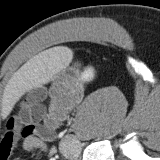

In [181]:
data["train"][287]["image"]

In [182]:
data["train"][287]["label"]

1

In [183]:

import torch
import random
from torchvision import transforms
from torchvision.transforms import functional as TF

# --- Your augmentations adapted for 2D PNGs ---
class AddGaussianNoise(object):
    def __init__(self, mean=0, std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        noise = torch.randn(tensor.size()) * self.std + self.mean
        return torch.clamp(tensor + noise, 0, 1)

class RandomGamma(object):
    def __init__(self, gamma_range=(0.5, 2), gain=1):
        self.gamma_range = gamma_range
        self.gain = gain

    def __call__(self, img):
        gamma = random.uniform(*self.gamma_range)
        img = img.float()
        img = torch.pow(img, gamma) * self.gain
        return torch.clamp(img, 0, 1)

class MultiplicativeBrightnessTransform(object):
    def __init__(self, multiplier_range=(0.75, 1.25)):
        self.multiplier_range = multiplier_range

    def __call__(self, img):
        multiplier = torch.FloatTensor(1).uniform_(*self.multiplier_range).item()
        return torch.clamp(img * multiplier, 0, 1)

class ContrastTransform:
    def __init__(self, contrast_range=(0.75, 1.25)):
        self.contrast_range = contrast_range

    def __call__(self, img):
        factor = random.uniform(*self.contrast_range)
        mean = img.mean()
        return torch.clamp((img - mean) * factor + mean, 0, 1)
    

class RandomRotationTensor:
    def __init__(self, degrees):
        if isinstance(degrees, int):
            degrees = (-degrees, degrees)
        elif isinstance(degrees, tuple) and degrees[0] > degrees[1]:
            degrees = (degrees[1], degrees[0])
        self.degrees = degrees

    def __call__(self, img):
        angle = random.uniform(*self.degrees)
        return TF.rotate(img, angle)

In [184]:
import random
from PIL import Image
import torchvision.transforms.functional as TF
import torch
import numpy as np
import matplotlib.pyplot as plt

def augment_train_batch_random_subset(examples, p=0.2):
    imgs = examples["image"]
    augmented_imgs = []

    # Define all possible transforms as functions
    def rotate(img):
        angle = random.uniform(-10, 10)
        return img.rotate(angle)

    def add_noise(img_tensor):
        std = random.uniform(0, 0.1)
        noise = torch.randn_like(img_tensor) * std
        return torch.clamp(img_tensor + noise, 0, 1)

    def gamma(img_tensor):
        g = random.uniform(0.7, 1.5)
        return torch.clamp(img_tensor ** g, 0, 1)

    def brightness(img_tensor):
        m = random.uniform(0.75, 2)
        return torch.clamp(img_tensor * m, 0, 1)

    def contrast(img_tensor):
        mean = img_tensor.mean()
        factor = random.uniform(0.75, 2)
        return torch.clamp((img_tensor - mean) * factor + mean, 0, 1)

    for img in imgs:
        # Start with the original PIL image
        current_img = img.copy()
        applied_transforms = []

        # Apply each transform independently with probability p
        if random.random() < p:
            current_img = rotate(current_img)
            applied_transforms.append("Rotate")
        
        # Convert to tensor for numerical transforms
        img_tensor = TF.to_tensor(current_img)
        
        if random.random() < p:
            img_tensor = add_noise(img_tensor)
            applied_transforms.append("Noise")
        
        if random.random() < p:
            img_tensor = gamma(img_tensor)
            applied_transforms.append("Gamma")
        
        if random.random() < p:
            img_tensor = brightness(img_tensor)
            applied_transforms.append("Brightness")
        
        if random.random() < p:
            img_tensor = contrast(img_tensor)
            applied_transforms.append("Contrast")
        
        # Convert back to PIL image
        augmented_img = TF.to_pil_image(img_tensor)
        augmented_imgs.append(augmented_img)

    examples["image"] = augmented_imgs
    return examples

Map:   0%|          | 0/6 [00:00<?, ? examples/s]

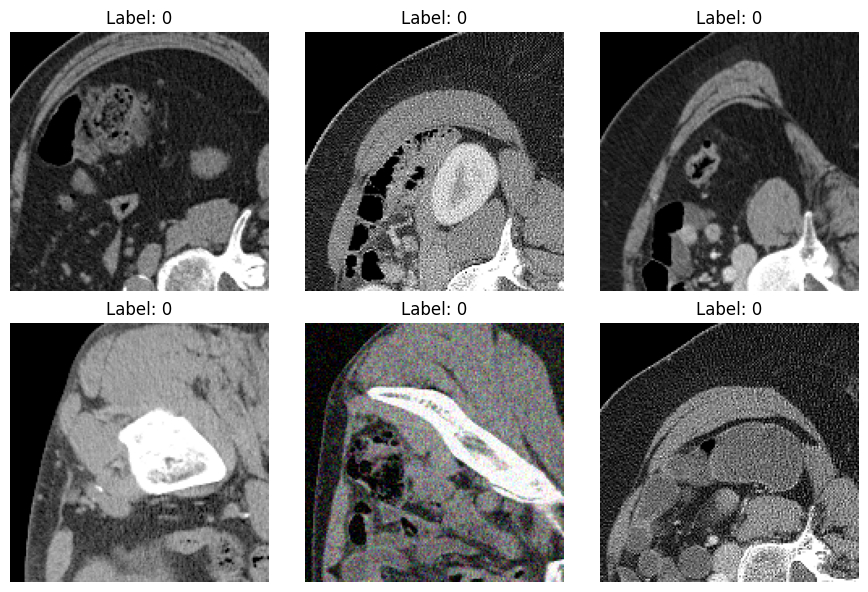

In [185]:
# Take first 6 examples from the training set
small_batch = data["train"].select(range(6))
augmented_batch = small_batch.map(augment_train_batch_random_subset, batched=True)

images = [ex["image"] for ex in augmented_batch]
labels = [ex["label"] for ex in augmented_batch]

# Number of columns (ceil of total / 2 rows)
n_rows = 2
n_cols = (len(images) + 1) // n_rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))

# Flatten axes for easy indexing
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(images):
        ax.imshow(images[i])
        ax.set_title(f"Label: {labels[i]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

## Fine-tune the model

Contrastive image-text learning is a method that trains models to learn the relationship between images and text, such that the representations of matching image-text pairs are brought closer together in a shared embedding space while non-matching pairs are pushed further apart.

This notebook demonstrates contrastive fine-tuning of MedSigLIP, where the vision and text encoders are jointly trained on image and text data, using the `Trainer` from the Hugging Face `Transformers` library.

Define a data collator to prepare batches of training examples.

In [ ]:
import torch
from transformers import AutoProcessor, AutoModel
import torch.nn as nn
from transformers import SiglipModel
from collections import Counter

model_id = "google/medsiglip-448"

class SiglipForClassification(nn.Module):
    def __init__(self, siglip_model, num_classes=1, pos_weight=None):  # num_classes=1 for binary classification
        super().__init__()
        self.siglip = siglip_model
        self.classifier = nn.Linear(siglip_model.config.vision_config.hidden_size, num_classes)
        if pos_weight is not None:
            # Use pos_weight for handling class imbalance
            self.loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight]))
        else:
            self.loss_fn = nn.BCEWithLogitsLoss()
        
    def forward(self, pixel_values, labels=None, **kwargs):
        # Get vision embeddings
        vision_outputs = self.siglip.vision_model(pixel_values=pixel_values)
        pooled_output = vision_outputs.pooler_output
        
        # Get logits (single output for binary classification)
        logits = self.classifier(pooled_output)  # Shape: [batch_size, 1]
        
        # Compute loss if labels are provided
        loss = None
        if labels is not None:
            # Ensure labels are float and have shape [batch_size, 1]
            labels = labels.view(-1, 1).float()  # Reshape and convert to float
            loss = self.loss_fn(logits, labels)
        
        return {
            "loss": loss,
            "logits": logits
        }

# Load base SigLIP model
base_model = SiglipModel.from_pretrained(model_id)

# count for weighted loss 

labels = [example["label"] for example in data["train"]]
counter = Counter(labels)

num_negatives = counter[0]  # normal
num_positives = counter[1]  # appendicitis

print(f"Number of negatives (normal): {num_negatives}")
print(f"Number of positives (appendicitis): {num_positives}")

# pos_weight = (num_negatives / num_positives)
pos_weight_value = num_negatives / num_positives

model = SiglipForClassification(base_model, num_classes=1, pos_weight=pos_weight_value)  # Binary classification
processor = AutoProcessor.from_pretrained(model_id)

In [ ]:
def collate_fn(examples):
    images = [example["image"] for example in examples]
    labels = [example["label"] for example in examples]
    paths = [example["path"] for example in examples]
    split = examples[0].get("split", "train")  # Assume a 'split' key or default to 'train'
    
    # Apply augmentation only to training data
    if split == "train":
        # Create a temporary dictionary for the batch to pass to augment_train_batch_random_subset
        temp_examples = {"image": images}
        augmented_examples = augment_train_batch_random_subset(temp_examples)
        augmented_images = augmented_examples["image"]
    else:
        augmented_images = images  # No augmentation for validation/test
    
    # Resize all images to 448x448 for medsiglip-448
    resized_images = [img.resize((448, 448), Image.Resampling.BILINEAR) for img in augmented_images]
    
    # Process images
    batch = processor(images=resized_images, return_tensors="pt")
    
    # Add labels and paths
    batch["labels"] = torch.tensor(labels, dtype=torch.float).view(-1, 1)
    batch["path"] = paths  # Keep paths as a list
    
    return batch

Configure training parameters in [`TrainingArguments`](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments).

In [ ]:
from transformers import TrainingArguments

num_train_epochs = 2  # @param {type: "number"}
learning_rate = 1e-5  # @param {type: "number"}

training_args = TrainingArguments(
    output_dir="medsiglip-appendicits-binary",  # Directory and Hub repository id to save the model to
    num_train_epochs=num_train_epochs,      # Number of training epochs
    per_device_train_batch_size=16,         # Batch size per device during training
    per_device_eval_batch_size=16,          # Batch size per device during evaluation
    gradient_accumulation_steps=2,          # Number of steps before performing a backward/update pass
    logging_steps=10,                       # Number of steps between logs
    #save_strategy="steps",                  # Save checkpoint every eval_steps
    #save_steps=100, # Save every 50 steps (same as eval_steps)
    save_strategy = "epoch",
    eval_strategy="steps",                  # Evaluate every `eval_steps`
    eval_steps=100,                          # Number of steps between evaluations
    learning_rate=learning_rate,            # Learning rate
    weight_decay=0.05,                      # Much stronger weight decay
    warmup_steps=100,                        # Number of steps for linear warmup from 0 to learning rate
    lr_scheduler_type="cosine", 
    bf16=True,
    fp16=False,
    tf32=True,
    load_best_model_at_end=True,            # Load the best model at the end of training
    metric_for_best_model="f1",             # Use F1 score to determine best model
    greater_is_better=True,                 # Higher F1 score is better
    push_to_hub=True,        
    remove_unused_columns=False,            # Push model to Hub
    report_to="tensorboard",                # Report metrics to tensorboard
)



In [14]:
import evaluate
import numpy as np
import pandas as pd

# Load the metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
roc_auc_metric = evaluate.load("roc_auc")

def compute_metrics(eval_pred):
    """
    Compute metrics for binary classification (normal vs. positive).
    """
    predictions, labels = eval_pred  # predictions: [batch_size, 1], labels: [batch_size]
    
    # Convert logits to probabilities and predictions
    probabilities = 1 / (1 + np.exp(-predictions))  # Sigmoid: [batch_size, 1]
    pred_classes = (probabilities > 0.5).astype(np.int32).flatten()  # Threshold at 0.5: [batch_size]
    
    # Ensure labels are integers
    labels = labels.astype(np.int32)
    
    # Compute metrics
    metrics = {}
    metrics.update(accuracy_metric.compute(
        predictions=pred_classes,
        references=labels,
    ))
    metrics.update(f1_metric.compute(
        predictions=pred_classes,
        references=labels,
        average ="macro"
    ))
    # Compute ROC-AUC using positive class probabilities
    try:
        auc = roc_auc_metric.compute(
            prediction_scores=probabilities.flatten(),  # Positive class probabilities
            references=labels,
            average="macro"  # Binary classification uses macro for consistency
        )
        metrics.update({"auc": auc["roc_auc"]})
    except Exception as e:
        metrics.update({"auc": None, "auc_error": str(e)})
    
    return metrics

Construct a [`Trainer`](https://huggingface.co/docs/transformers/trainer) using the previously defined training parameters and data collator.

In [15]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data["train"],
    eval_dataset=data["validation"].shuffle().select(range(100)),  # Use subset of validation set for faster run
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
)

Launch the fine-tuning process.

In [16]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Auc
100,1.173700,1.159028,0.583333,0.368421,0.863839
200,0.939300,0.420564,0.812500,0.807143,0.891964
300,0.798700,0.447338,0.760417,0.732526,0.901786
400,0.694500,0.365135,0.843750,0.835897,0.933036
500,0.710200,0.371234,0.843750,0.842365,0.929911
600,0.546500,0.394609,0.864583,0.860199,0.931250
700,0.524600,0.316223,0.885417,0.882549,0.944196
800,0.420400,0.353166,0.895833,0.890060,0.942411
900,0.362800,0.388113,0.864583,0.859063,0.941518
1000,0.239200,0.446685,0.895833,0.892038,0.944196


TrainOutput(global_step=1904, training_loss=0.39890826911422883, metrics={'train_runtime': 15715.0076, 'train_samples_per_second': 3.875, 'train_steps_per_second': 0.121, 'total_flos': 0.0, 'train_loss': 0.39890826911422883, 'epoch': 2.0})

## Evaluate the fine-tuned model on a classification task

In [17]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import (
    accuracy_score, 
    precision_recall_fscore_support, 
    classification_report, 
    confusion_matrix
)
from tqdm import tqdm

def evaluate_model(model, train_dataset, processor, batch_size=32, device='cuda'):
    """
    Comprehensive evaluation of the fine-tuned model on train data
    """
    model.eval()
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        collate_fn=collate_fn
    )
    all_predictions = []
    all_labels = []
    all_logits = []
    all_paths = []
    print("Evaluating model on train dataset...")
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(train_loader, desc="Testing")):
            if 'pixel_values' not in batch or 'labels' not in batch:
                raise ValueError("Batch missing required keys: 'pixel_values' or 'labels'.")
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)
            paths = batch['path']
            outputs = model(pixel_values=pixel_values)
            logits = outputs['logits']
            probabilities = torch.sigmoid(logits)
            predictions = (probabilities > 0.4).long().view(-1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_logits.extend(probabilities.cpu().numpy().flatten())  # Save probabilities
            all_paths.extend(paths)
    return np.array(all_predictions), np.array(all_labels), np.array(all_logits), all_paths


def compute_detailed_metrics(predictions, labels, class_names):
    """
    Compute detailed evaluation metrics
    """
    
    # Basic metrics
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, support = precision_recall_fscore_support(
        labels, predictions, average=None
    )
    
    # Weighted averages
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted'
    )
    
    # Macro averages
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        labels, predictions, average='macro'
    )
    
    print("="*50)
    print("EVALUATION RESULTS")
    print("="*50)
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Weighted F1-Score: {f1_weighted:.4f}")
    print(f"Macro F1-Score: {f1_macro:.4f}")
    print()
    
    # Per-class metrics
    print("Per-Class Metrics:")
    print("-" * 70)
    print(f"{'Class':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
    print("-" * 70)
    
    for i, class_name in enumerate(class_names):
        print(f"{class_name:<15} {precision[i]:<12.4f} {recall[i]:<12.4f} {f1[i]:<12.4f} {support[i]:<10}")
    
    print("-" * 70)
    print(f"{'Weighted Avg':<15} {precision_weighted:<12.4f} {recall_weighted:<12.4f} {f1_weighted:<12.4f} {sum(support):<10}")
    print(f"{'Macro Avg':<15} {precision_macro:<12.4f} {recall_macro:<12.4f} {f1_macro:<12.4f} {sum(support):<10}")
    
    return {
        'accuracy': accuracy,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'per_class_precision': precision,
        'per_class_recall': recall,
        'per_class_f1': f1,
        'support': support
    }


def run_evaluation():
    ABDOMINAL_PAIN_CLASSES = ['normal', 'appendicitis']
    train_data = data["train"]
    print(f"Train dataset size: {len(train_data)}")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    predictions, labels, probabilities, paths = evaluate_model(
        model, 
        train_data, 
        processor, 
        batch_size=32, 
        device=device
    )
    metrics = compute_detailed_metrics(predictions, labels, ABDOMINAL_PAIN_CLASSES)
    print("\nDetailed Classification Report:")
    print("="*50)
    print(classification_report(
        labels, 
        predictions, 
        target_names=ABDOMINAL_PAIN_CLASSES,
        digits=4
    ))
    # Save results to Excel
    df_results = pd.DataFrame({
        "image_path": paths,
        "probability": probabilities,
        "actual_label": labels.flatten(),
        "prediction": predictions.flatten()
    })
    df_results.to_excel("train_predictions.xlsx", index=False)
    print("✅ Results saved to train_predictions.xlsx")
    return metrics, predictions, labels, probabilities, paths

# Run the evaluation
evaluation_results = run_evaluation()

Train dataset size: 30450
Evaluating model on train dataset...


Testing: 100%|██████████| 952/952 [1:03:38<00:00,  4.01s/it]


EVALUATION RESULTS
Overall Accuracy: 0.9988
Weighted F1-Score: 0.9988
Macro F1-Score: 0.9987

Per-Class Metrics:
----------------------------------------------------------------------
Class           Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
normal          0.9992       0.9991       0.9991       20090     
appendicitis    0.9982       0.9984       0.9983       10360     
----------------------------------------------------------------------
Weighted Avg    0.9988       0.9988       0.9988       30450     
Macro Avg       0.9987       0.9987       0.9987       30450     

Detailed Classification Report:
              precision    recall  f1-score   support

      normal     0.9992    0.9991    0.9991     20090
appendicitis     0.9982    0.9984    0.9983     10360

    accuracy                         0.9988     30450
   macro avg     0.9987    0.9987    0.9987     30450
weighted avg     0.9988    0.9988    0.

In [21]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import (
    accuracy_score, 
    precision_recall_fscore_support, 
    classification_report, 
    confusion_matrix
)
from tqdm import tqdm

def evaluate_model(model, valid_dataset, processor, batch_size=32, device='cuda'):
    """
    Comprehensive evaluation of the fine-tuned model on valid data
    """
    model.eval()
    valid_loader = DataLoader(
        valid_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        collate_fn=collate_fn
    )
    all_predictions = []
    all_labels = []
    all_logits = []
    all_paths = []
    print("Evaluating model on valid dataset...")
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(valid_loader, desc="Testing")):
            if 'pixel_values' not in batch or 'labels' not in batch:
                raise ValueError("Batch missing required keys: 'pixel_values' or 'labels'.")
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)
            paths = batch['path']
            outputs = model(pixel_values=pixel_values)
            logits = outputs['logits']
            probabilities = torch.sigmoid(logits)
            predictions = (probabilities > 0.4).long().view(-1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_logits.extend(probabilities.cpu().numpy().flatten())  # Save probabilities
            all_paths.extend(paths)
    return np.array(all_predictions), np.array(all_labels), np.array(all_logits), all_paths


def compute_detailed_metrics(predictions, labels, class_names):
    """
    Compute detailed evaluation metrics
    """
    
    # Basic metrics
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, support = precision_recall_fscore_support(
        labels, predictions, average=None
    )
    
    # Weighted averages
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted'
    )
    
    # Macro averages
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        labels, predictions, average='macro'
    )
    
    print("="*50)
    print("EVALUATION RESULTS")
    print("="*50)
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Weighted F1-Score: {f1_weighted:.4f}")
    print(f"Macro F1-Score: {f1_macro:.4f}")
    print()
    
    # Per-class metrics
    print("Per-Class Metrics:")
    print("-" * 70)
    print(f"{'Class':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
    print("-" * 70)
    
    for i, class_name in enumerate(class_names):
        print(f"{class_name:<15} {precision[i]:<12.4f} {recall[i]:<12.4f} {f1[i]:<12.4f} {support[i]:<10}")
    
    print("-" * 70)
    print(f"{'Weighted Avg':<15} {precision_weighted:<12.4f} {recall_weighted:<12.4f} {f1_weighted:<12.4f} {sum(support):<10}")
    print(f"{'Macro Avg':<15} {precision_macro:<12.4f} {recall_macro:<12.4f} {f1_macro:<12.4f} {sum(support):<10}")
    
    return {
        'accuracy': accuracy,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'per_class_precision': precision,
        'per_class_recall': recall,
        'per_class_f1': f1,
        'support': support
    }


def run_evaluation():
    ABDOMINAL_PAIN_CLASSES = ['normal', 'appendicitis']
    valid_data = data["validation"]
    print(f"Validation dataset size: {len(valid_data)}")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    predictions, labels, probabilities, paths = evaluate_model(
        model, 
        valid_data, 
        processor, 
        batch_size=32, 
        device=device
    )
    metrics = compute_detailed_metrics(predictions, labels, ABDOMINAL_PAIN_CLASSES)
    print("\nDetailed Classification Report:")
    print("="*50)
    print(classification_report(
        labels, 
        predictions, 
        target_names=ABDOMINAL_PAIN_CLASSES,
        digits=4
    ))
    # Save results to Excel
    df_results = pd.DataFrame({
        "image_path": paths,
        "probability": probabilities,
        "actual_label": labels.flatten(),
        "prediction": predictions.flatten()
    })
    df_results.to_excel("validation_predictions.xlsx", index=False)
    print("✅ Results saved to validation_predictions.xlsx")
    return metrics, predictions, labels, probabilities, paths

# Run the evaluation
evaluation_results = run_evaluation()

Validation dataset size: 7630
Evaluating model on valid dataset...


Testing: 100%|██████████| 239/239 [16:30<00:00,  4.15s/it]


EVALUATION RESULTS
Overall Accuracy: 0.8197
Weighted F1-Score: 0.8191
Macro F1-Score: 0.8068

Per-Class Metrics:
----------------------------------------------------------------------
Class           Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
normal          0.8494       0.8641       0.8567       4760      
appendicitis    0.7679       0.7460       0.7568       2870      
----------------------------------------------------------------------
Weighted Avg    0.8188       0.8197       0.8191       7630      
Macro Avg       0.8087       0.8050       0.8068       7630      

Detailed Classification Report:
              precision    recall  f1-score   support

      normal     0.8494    0.8641    0.8567      4760
appendicitis     0.7679    0.7460    0.7568      2870

    accuracy                         0.8197      7630
   macro avg     0.8087    0.8050    0.8068      7630
weighted avg     0.8188    0.8197    0.

In [22]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import (
    accuracy_score, 
    precision_recall_fscore_support, 
    classification_report, 
    confusion_matrix
)
from tqdm import tqdm

def evaluate_model(model, test_dataset, processor, batch_size=32, device='cuda'):
    """
    Comprehensive evaluation of the fine-tuned model on test data
    """
    model.eval()
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        collate_fn=collate_fn
    )
    all_predictions = []
    all_labels = []
    all_logits = []
    all_paths = []
    print("Evaluating model on test dataset...")
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(test_loader, desc="Testing")):
            if 'pixel_values' not in batch or 'labels' not in batch:
                raise ValueError("Batch missing required keys: 'pixel_values' or 'labels'.")
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)
            paths = batch['path']
            outputs = model(pixel_values=pixel_values)
            logits = outputs['logits']
            probabilities = torch.sigmoid(logits)
            predictions = (probabilities > 0.4).long().view(-1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_logits.extend(probabilities.cpu().numpy().flatten())  # Save probabilities
            all_paths.extend(paths)
    return np.array(all_predictions), np.array(all_labels), np.array(all_logits), all_paths


def compute_detailed_metrics(predictions, labels, class_names):
    """
    Compute detailed evaluation metrics
    """
    
    # Basic metrics
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, support = precision_recall_fscore_support(
        labels, predictions, average=None
    )
    
    # Weighted averages
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted'
    )
    
    # Macro averages
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        labels, predictions, average='macro'
    )
    
    print("="*50)
    print("EVALUATION RESULTS")
    print("="*50)
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Weighted F1-Score: {f1_weighted:.4f}")
    print(f"Macro F1-Score: {f1_macro:.4f}")
    print()
    
    # Per-class metrics
    print("Per-Class Metrics:")
    print("-" * 70)
    print(f"{'Class':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
    print("-" * 70)
    
    for i, class_name in enumerate(class_names):
        print(f"{class_name:<15} {precision[i]:<12.4f} {recall[i]:<12.4f} {f1[i]:<12.4f} {support[i]:<10}")
    
    print("-" * 70)
    print(f"{'Weighted Avg':<15} {precision_weighted:<12.4f} {recall_weighted:<12.4f} {f1_weighted:<12.4f} {sum(support):<10}")
    print(f"{'Macro Avg':<15} {precision_macro:<12.4f} {recall_macro:<12.4f} {f1_macro:<12.4f} {sum(support):<10}")
    
    return {
        'accuracy': accuracy,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'per_class_precision': precision,
        'per_class_recall': recall,
        'per_class_f1': f1,
        'support': support
    }


def run_evaluation():
    ABDOMINAL_PAIN_CLASSES = ['normal', 'appendicitis']
    test_data = data["test"]
    print(f"Test dataset size: {len(test_data)}")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    predictions, labels, probabilities, paths = evaluate_model(
        model, 
        test_data, 
        processor, 
        batch_size=32, 
        device=device
    )
    metrics = compute_detailed_metrics(predictions, labels, ABDOMINAL_PAIN_CLASSES)
    print("\nDetailed Classification Report:")
    print("="*50)
    print(classification_report(
        labels, 
        predictions, 
        target_names=ABDOMINAL_PAIN_CLASSES,
        digits=4
    ))
    # Save results to Excel
    df_results = pd.DataFrame({
        "image_path": paths,
        "probability": probabilities,
        "actual_label": labels.flatten(),
        "prediction": predictions.flatten()
    })
    df_results.to_excel("test_predictions.xlsx", index=False)
    print("✅ Results saved to test_predictions.xlsx")
    return metrics, predictions, labels, probabilities, paths

# Run the evaluation
evaluation_results = run_evaluation()

Test dataset size: 9590
Evaluating model on test dataset...


Testing: 100%|██████████| 300/300 [20:47<00:00,  4.16s/it]


EVALUATION RESULTS
Overall Accuracy: 0.7855
Weighted F1-Score: 0.7840
Macro F1-Score: 0.7611

Per-Class Metrics:
----------------------------------------------------------------------
Class           Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
normal          0.8247       0.8506       0.8375       6230      
appendicitis    0.7058       0.6649       0.6848       3360      
----------------------------------------------------------------------
Weighted Avg    0.7831       0.7855       0.7840       9590      
Macro Avg       0.7653       0.7577       0.7611       9590      

Detailed Classification Report:
              precision    recall  f1-score   support

      normal     0.8247    0.8506    0.8375      6230
appendicitis     0.7058    0.6649    0.6848      3360

    accuracy                         0.7855      9590
   macro avg     0.7653    0.7577    0.7611      9590
weighted avg     0.7831    0.7855    0.